# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import accuracy_fn, cohen_kappa_fn
from models import PretrainedCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("../images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

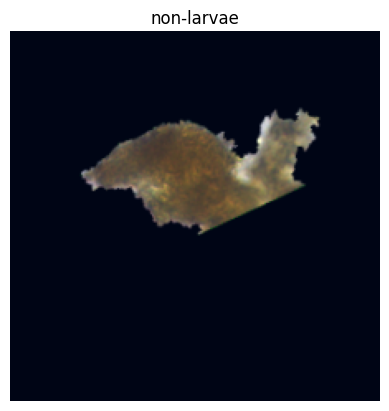

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="mobilenet_v2",
    use_dropout=True,
)
summary(cnn_0, input_shape)

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/gio/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:05<00:00, 2.50MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/pre_cnn_0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.4935 | Val Loss: 0.3228 | Train cohen_kappa_fn: 0.5089 | Val cohen_kappa_fn: 0.4849 | Train accuracy_fn: 0.8073 | Val accuracy_fn: 0.8056
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.2361 | Val Loss: 0.2048 | Train cohen_kappa_fn: 0.6340 | Val cohen_kappa_fn: 0.6762 | Train accuracy_fn: 0.8711 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2019 | Val Loss: 0.1580 | Train cohen_kappa_fn: 0.7787 | Val cohen_kappa_fn: 0.7510 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.1742 | Val Loss: 0.1708 | Train cohen_kappa_fn: 0.9096 | Val cohen_kappa_fn: 0.8846 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 5 | Train Loss: 0.1422 | Val Loss: 0.1220 | Train cohen_kappa_fn: 0.8501 | Val cohen_kappa_fn: 0.8580 | Train accuracy_fn: 0.9562 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.1454 | Val Loss: 0.1252 | Train cohen_kappa_fn: 0.8783 | Val cohen_kappa_fn: 0.8138 | Train accuracy_fn: 0.9650 | Val accuracy_fn: 0.9498
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1613 | Val Loss: 0.1250 | Train cohen_kappa_fn: 0.7925 | Val cohen_kappa_fn: 0.7973 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.9436
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1419 | Val Loss: 0.1328 | Train cohen_kappa_fn: 0.7572 | Val cohen_kappa_fn: 0.7783 | Train accuracy_fn: 0.9237 | Val accuracy_fn: 0.9373
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.1377 | Val Loss: 0.1084 | Train cohen_kappa_fn: 0.8406 | Val cohen_kappa_fn: 0.8580 | Train accuracy_fn: 0.9537 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1171 | Val Loss: 0.0978 | Train cohen_kappa_fn: 0.8904 | Val cohen_kappa_fn: 0.8887 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1162 | Val Loss: 0.1026 | Train cohen_kappa_fn: 0.8809 | Val cohen_kappa_fn: 0.8907 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1174 | Val Loss: 0.1210 | Train cohen_kappa_fn: 0.7619 | Val cohen_kappa_fn: 0.8101 | Train accuracy_fn: 0.9249 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1279 | Val Loss: 0.1131 | Train cohen_kappa_fn: 0.9390 | Val cohen_kappa_fn: 0.8616 | Train accuracy_fn: 0.9837 | Val accuracy_fn: 0.9655
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1329 | Val Loss: 0.1013 | Train cohen_kappa_fn: 0.9189 | Val cohen_kappa_fn: 0.8753 | Train accuracy_fn: 0.9775 | Val accuracy_fn: 0.9687
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.0994 | Val Loss: 0.1096 | Train cohen_kappa_fn: 0.8149 | Val cohen_kappa_fn: 0.8297 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9530
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


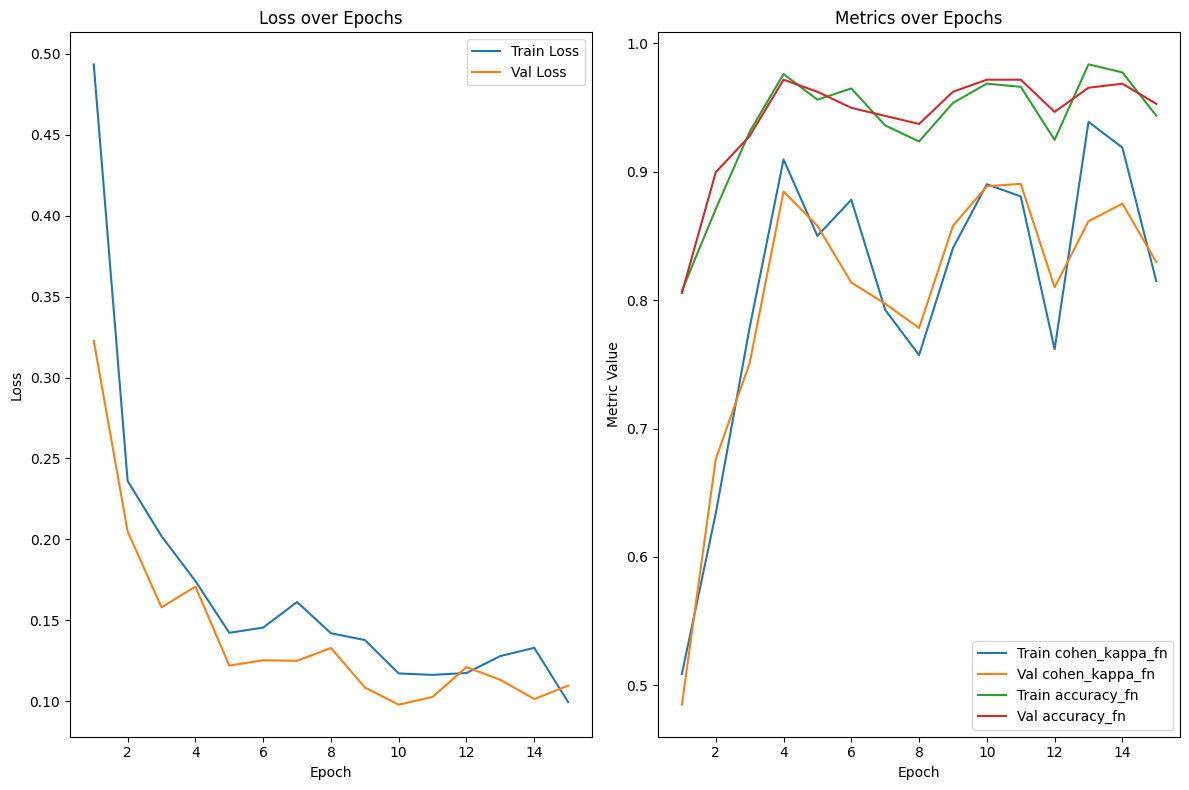

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
test_loss, test_metrics = trainer_cnn_0.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_0.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.1418 | Test cohen_kappa_fn: 0.7089 | Test accuracy_fn: 0.9042


### 3.3. CNN1

In [14]:
cnn_1 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="squeezenet1_0",
    use_dropout=True,
)
summary(cnn_1, input_shape)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /home/gio/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4.78M/4.78M [00:02<00:00, 1.76MB/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x86528 and 512x128)

In [ ]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/pre_cnn_1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [ ]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7338 | Val Loss: 0.5784 | Train cohen_kappa_fn: 0.2152 | Val cohen_kappa_fn: 0.2954 | Train accuracy_fn: 0.6395 | Val accuracy_fn: 0.7962
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5849 | Val Loss: 0.5848 | Train cohen_kappa_fn: 0.2535 | Val cohen_kappa_fn: 0.2171 | Train accuracy_fn: 0.6258 | Val accuracy_fn: 0.6583
  ❄️ Performance droped, model won't be saved!


📘 Epoch 3 | Train Loss: 0.5310 | Val Loss: 0.5861 | Train cohen_kappa_fn: 0.1642 | Val cohen_kappa_fn: 0.1198 | Train accuracy_fn: 0.5044 | Val accuracy_fn: 0.4922
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5356 | Val Loss: 0.5641 | Train cohen_kappa_fn: 0.2179 | Val cohen_kappa_fn: 0.1617 | Train accuracy_fn: 0.5845 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5787 | Val Loss: 0.5798 | Train cohen_kappa_fn: 0.1967 | Val cohen_kappa_fn: 0.2053 | Train accuracy_fn: 0.5319 | Val accuracy_fn: 0.5893
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5108 | Val Loss: 0.5842 | Train cohen_kappa_fn: 0.3030 | Val cohen_kappa_fn: 0.1082 | Train accuracy_fn: 0.6984 | Val accuracy_fn: 0.5392
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4925 | Val Loss: 0.5594 | Train cohen_kappa_fn: 0.4657 | Val cohen_kappa_fn: 0.3303 | Train accuracy_fn: 0.8686 | Val accuracy_fn: 0.8840
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5236 | Val Loss: 0.4508 | Train cohen_kappa_fn: 0.3366 | Val cohen_kappa_fn: 0.3807 | Train accuracy_fn: 0.7084 | Val accuracy_fn: 0.7712
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4826 | Val Loss: 0.4680 | Train cohen_kappa_fn: 0.4911 | Val cohen_kappa_fn: 0.6056 | Train accuracy_fn: 0.8461 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.5117 | Val Loss: 0.4957 | Train cohen_kappa_fn: 0.4518 | Val cohen_kappa_fn: 0.5454 | Train accuracy_fn: 0.8360 | Val accuracy_fn: 0.9091
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4555 | Val Loss: 0.4639 | Train cohen_kappa_fn: 0.4320 | Val cohen_kappa_fn: 0.4509 | Train accuracy_fn: 0.7897 | Val accuracy_fn: 0.8339
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4481 | Val Loss: 0.4904 | Train cohen_kappa_fn: 0.5353 | Val cohen_kappa_fn: 0.3052 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7712
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4424 | Val Loss: 0.4706 | Train cohen_kappa_fn: 0.4047 | Val cohen_kappa_fn: 0.2962 | Train accuracy_fn: 0.7572 | Val accuracy_fn: 0.6708
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


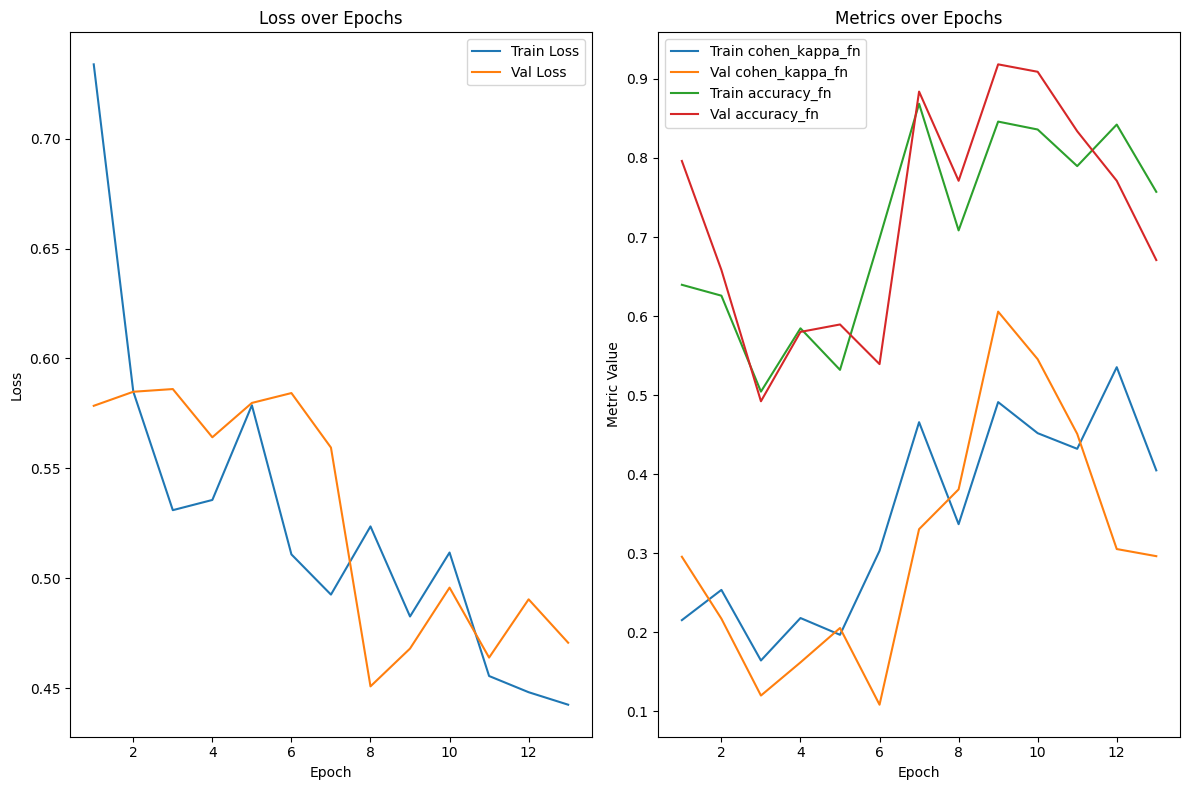

In [ ]:
trainer_cnn_1.plot_epochs()

In [ ]:
test_loss, test_metrics = trainer_cnn_1.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_1.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.4711 | Test cohen_kappa_fn: 0.3233 | Test accuracy_fn: 0.7063


### 3.4. CNN2

In [15]:
cnn_2 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="resnet18",
    use_dropout=True,
)
summary(cnn_2, input_shape)

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/gio/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:18<00:00, 2.59MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/pre_cnn_2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [17]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.5483 | Val Loss: 0.4091 | Train cohen_kappa_fn: 0.5509 | Val cohen_kappa_fn: 0.5289 | Train accuracy_fn: 0.8310 | Val accuracy_fn: 0.8307
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.3444 | Val Loss: 0.2725 | Train cohen_kappa_fn: 0.6792 | Val cohen_kappa_fn: 0.6083 | Train accuracy_fn: 0.8936 | Val accuracy_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2368 | Val Loss: 0.2315 | Train cohen_kappa_fn: 0.7356 | Val cohen_kappa_fn: 0.6811 | Train accuracy_fn: 0.9186 | Val accuracy_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2391 | Val Loss: 0.2227 | Train cohen_kappa_fn: 0.7158 | Val cohen_kappa_fn: 0.6563 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2174 | Val Loss: 0.2200 | Train cohen_kappa_fn: 0.7546 | Val cohen_kappa_fn: 0.6644 | Train accuracy_fn: 0.9237 | Val accuracy_fn: 0.9028
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.1689 | Val Loss: 0.2171 | Train cohen_kappa_fn: 0.7878 | Val cohen_kappa_fn: 0.6811 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.1689 | Val Loss: 0.2092 | Train cohen_kappa_fn: 0.8251 | Val cohen_kappa_fn: 0.6984 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9154
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2078 | Val Loss: 0.2110 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7898 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.1997 | Val Loss: 0.1972 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.6861 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9091
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1974 | Val Loss: 0.2095 | Train cohen_kappa_fn: 0.7539 | Val cohen_kappa_fn: 0.6666 | Train accuracy_fn: 0.9224 | Val accuracy_fn: 0.8997
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1772 | Val Loss: 0.2010 | Train cohen_kappa_fn: 0.8036 | Val cohen_kappa_fn: 0.7297 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1497 | Val Loss: 0.1957 | Train cohen_kappa_fn: 0.8415 | Val cohen_kappa_fn: 0.7672 | Train accuracy_fn: 0.9537 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1378 | Val Loss: 0.1937 | Train cohen_kappa_fn: 0.8069 | Val cohen_kappa_fn: 0.7118 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9185
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1640 | Val Loss: 0.2038 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.6745 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9028
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1332 | Val Loss: 0.2014 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.7770 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1416 | Val Loss: 0.1877 | Train cohen_kappa_fn: 0.8790 | Val cohen_kappa_fn: 0.7207 | Train accuracy_fn: 0.9650 | Val accuracy_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1472 | Val Loss: 0.1885 | Train cohen_kappa_fn: 0.8877 | Val cohen_kappa_fn: 0.7869 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9436
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1486 | Val Loss: 0.1993 | Train cohen_kappa_fn: 0.8047 | Val cohen_kappa_fn: 0.7118 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1322 | Val Loss: 0.1890 | Train cohen_kappa_fn: 0.8680 | Val cohen_kappa_fn: 0.7482 | Train accuracy_fn: 0.9625 | Val accuracy_fn: 0.9310
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1069 | Val Loss: 0.1973 | Train cohen_kappa_fn: 0.8377 | Val cohen_kappa_fn: 0.7482 | Train accuracy_fn: 0.9537 | Val accuracy_fn: 0.9310
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1145 | Val Loss: 0.1886 | Train cohen_kappa_fn: 0.8359 | Val cohen_kappa_fn: 0.7389 | Train accuracy_fn: 0.9512 | Val accuracy_fn: 0.9279
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


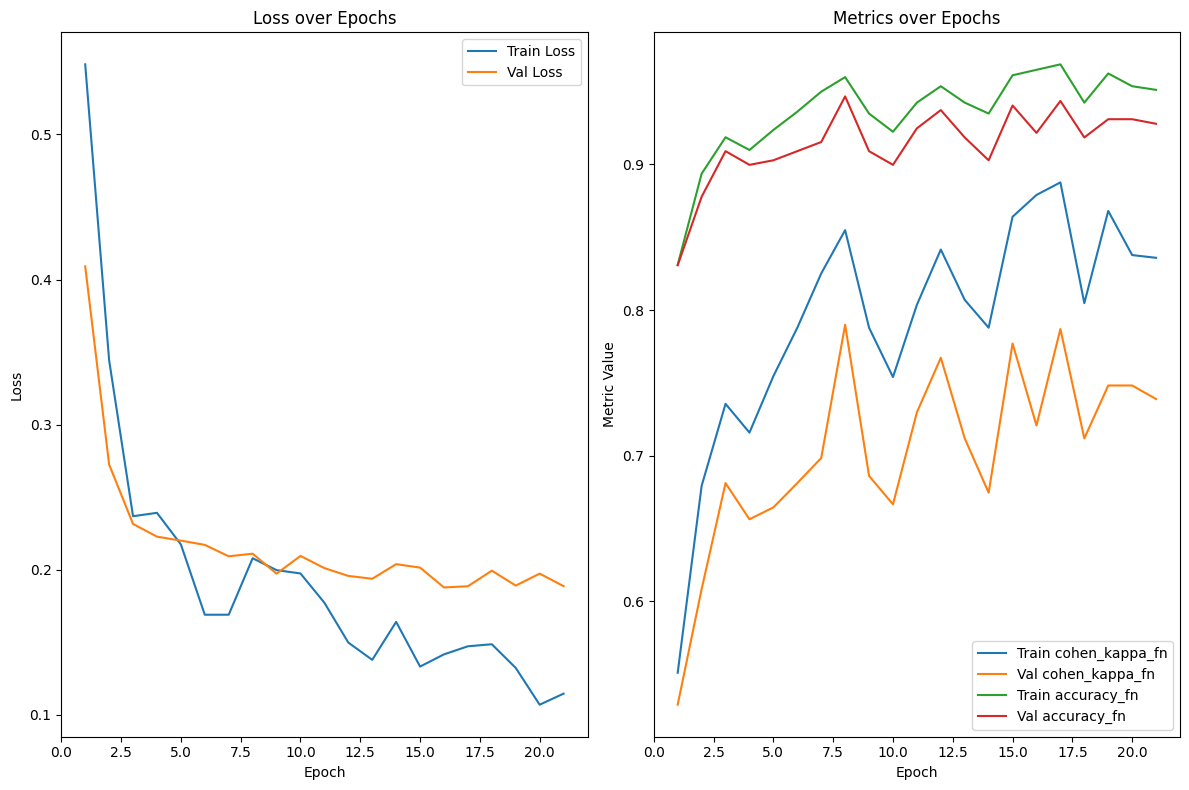

In [18]:
trainer_cnn_2.plot_epochs()

In [19]:
test_loss, test_metrics = trainer_cnn_2.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_2.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.1283 | Test cohen_kappa_fn: 0.7941 | Test accuracy_fn: 0.9375
